# Курсовое домашнее задание 1

Выполнил: Чемров Кирилл Сергеевич, группа Б01-811

Преподаватели: Грабовой Андрей Валериевич, Воронцов Константин Вячеславовоич

Вывод генератора заданий:

*   chemrov.ks@phystech.edu
*   id = 629914974
*   Регрессия
*   Boston Housing Data Set
*   Перцептрон, SVR, Линейная регрессия

# Библиотеки

In [87]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q matplotlib==3.1.3
    !pip install -q seaborn==0.11.2
    !pip install -q pandas==1.1.0
    !pip install -q tqdm==4.48.2
    !pip install -q numpy==1.19.1
    !pip install -q torch==1.9.0
    !pip install -q scikit-learn==0.23.2
    !pip install -q imgaug==0.2.6

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, ParameterGrid
from sklearn.svm import SVR
import torch
from torchvision import datasets
from torchvision import transforms

# Анализ выборки и препроцессинг данных

In [89]:
# Загрузка выборки
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data_np = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
data = pd.DataFrame(data_np)

column_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
# _v_features_v_
#  CRIM     per capita crime rate by town
#  ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#  INDUS    proportion of non-retail business acres per town
#  CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  NOX      nitric oxides concentration (parts per 10 million)
#  RM       average number of rooms per dwelling
#  AGE      proportion of owner-occupied units built prior to 1940
#  DIS      weighted distances to five Boston employment centres
#  RAD      index of accessibility to radial highways
#  TAX      full-value property-tax rate per $10,000
#  PTRATIO  pupil-teacher ratio by town
#  B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#  LSTAT    % lower status of the population

# _v_target_v_
#  MEDV     Median value of owner-occupied homes in $1000's
data.columns = column_names

Размер выборки 506. 13 признаков, все являются количесвтенными. Целевая переменная -- стоимость жилья (MEDV). То есть имеем задачу регрессии, так как необходимо восстановить функцию из множества объектов (13 признаков) во множество ответов (стоимость жилья).

Проверим, имеются ли пропуски значений в выборке. Нули ниже говорят, что пропуски отсутсвуют.

In [90]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Разделим выборку на обучающую (80%) и тестовую (20%) части. Далее будем анализировать только обучающую выборку, а на тестовой проверим качество работы итоговых моделей.

In [91]:
Data_train, Data_test = train_test_split(data, test_size = 0.2, random_state=1)
Data_train.sample(10, random_state=1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
384,20.08490,0.0,18.10,0.0,0.700,4.368,91.2,1.4395,24.0,666.0,20.2,285.83,30.63,8.8
422,12.04820,0.0,18.10,0.0,0.614,5.648,87.6,1.9512,24.0,666.0,20.2,291.55,14.10,20.8
68,0.13554,12.5,6.07,0.0,0.409,5.594,36.8,6.4980,4.0,345.0,18.9,396.90,13.09,17.4
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9
188,0.12579,45.0,3.44,0.0,0.437,6.556,29.1,4.5667,5.0,398.0,15.2,382.84,4.56,29.8
262,0.52014,20.0,3.97,0.0,0.647,8.398,91.5,2.2885,5.0,264.0,13.0,386.86,5.91,48.8
114,0.14231,0.0,10.01,0.0,0.547,6.254,84.2,2.2565,6.0,432.0,17.8,388.74,10.45,18.5
333,0.05083,0.0,5.19,0.0,0.515,6.316,38.1,6.4584,5.0,224.0,20.2,389.71,5.68,22.2
318,0.40202,0.0,9.90,0.0,0.544,6.382,67.2,3.5325,4.0,304.0,18.4,395.21,10.36,23.1
251,0.21409,22.0,5.86,0.0,0.431,6.438,8.9,7.3967,7.0,330.0,19.1,377.07,3.59,24.8


Нормируем обучающую выборку, затем, используя тот же fit, нормируем тестовую часть.

In [92]:
scaler = StandardScaler()
Dnorm_train = scaler.fit_transform(Data_train)
Dnorm_train = pd.DataFrame(Dnorm_train, columns=column_names)
Dnorm_test = scaler.transform(Data_test)
Dnorm_test = pd.DataFrame(Dnorm_test, columns=column_names)
Dnorm_train.sample(10, random_state=1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
360,1.793837,-0.495593,1.026692,-0.293294,1.258877,-2.761274,0.815497,-1.126625,1.675959,1.556337,0.812904,-0.780105,2.476801,-1.526759
62,0.914107,-0.495593,1.026692,-0.293294,0.522260,-0.901822,0.689305,-0.885071,1.675959,1.556337,0.812904,-0.717543,0.183346,-0.191623
374,-0.389902,0.041823,-0.732098,-0.293294,-1.233630,-0.980268,-1.091414,1.261294,-0.630983,-0.345084,0.212936,0.434727,0.043214,-0.569912
92,-0.399549,-0.495593,0.124636,-0.293294,0.171082,-0.346892,0.450941,-0.623644,-0.977024,-0.771571,1.182115,0.434727,-0.679648,-1.181849
146,-0.390969,1.439105,-1.116605,-0.293294,-0.993801,0.417226,-1.361326,0.349603,-0.515636,-0.031142,-1.494665,0.280945,-1.140281,0.809729
292,-0.347802,0.364272,-1.039119,-0.293294,0.804915,3.093092,0.826013,-0.725845,-0.515636,-0.824881,-2.509996,0.324914,-0.952976,2.923695
238,-0.389161,-0.495593,-0.156069,-0.293294,-0.051617,-0.021488,0.570123,-0.740951,-0.400289,0.170255,-0.294729,0.345476,-0.323073,-0.447524
296,-0.399175,-0.495593,-0.860754,-0.293294,-0.325707,0.068579,-1.045844,1.242600,-0.515636,-1.061819,0.812904,0.356086,-0.984887,-0.035857
29,-0.360732,-0.495593,-0.172151,-0.293294,-0.077313,0.164457,-0.025787,-0.138602,-0.630983,-0.587944,-0.017821,0.416242,-0.335560,0.064278
172,-0.381303,0.450259,-0.762800,-0.293294,-1.045193,0.245808,-2.069407,1.685534,-0.284942,-0.433935,0.305239,0.217835,-1.274864,0.253423


Построим распределение целевой переменной. Значения распределены нормально с некоторым количеством выбросом.

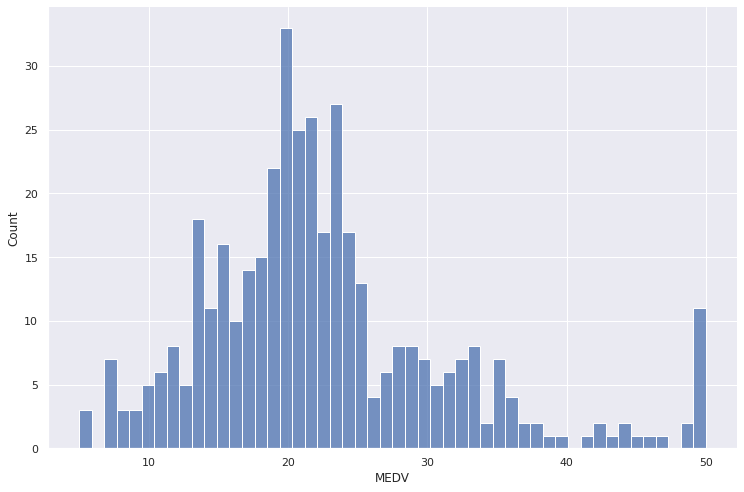

In [93]:
sns.displot(Data_train['MEDV'], bins=50, height=7, aspect=1.5)
plt.show()

Построим матрицу корреляции, которая покажет линейные отношения между переменными. Коэффиценты, близкие по модулю к 1, показывают высокую скоррелированность переменных. Например, LSTAT и RM имеют наибольшую корреляцию с целевой переменной MEDV. TAX и RAD сильно скоррелированы, поэтому один из признаков можно будет не использовать. 

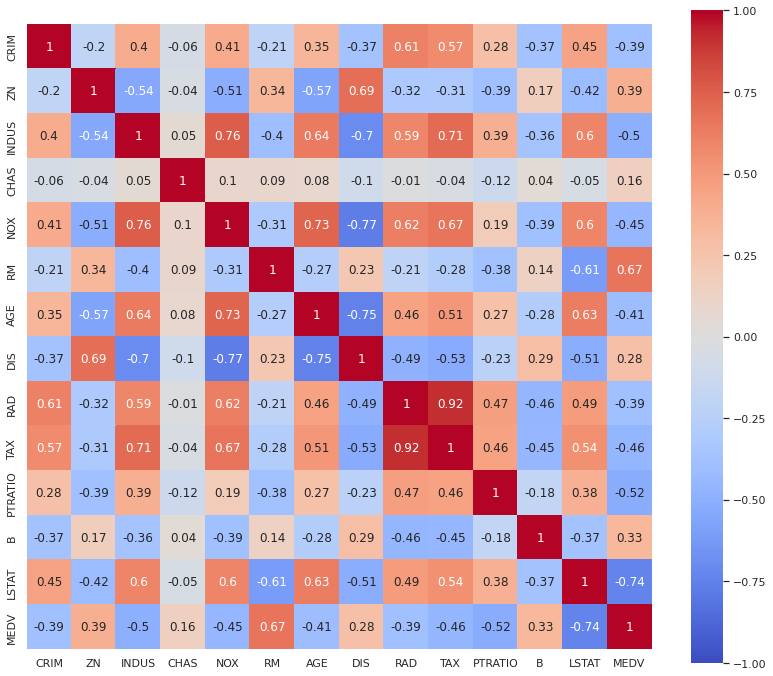

In [94]:
corr_matrix = Data_train.corr().round(2)
sns.set(rc={'figure.figsize':(14,12)})
sns.heatmap(corr_matrix, annot=True, square=True, cmap='coolwarm',vmin=-1, vmax=1)

Посмотрим графики зависимости целевой переменной от наиболее скоррелированных с ней признаков.

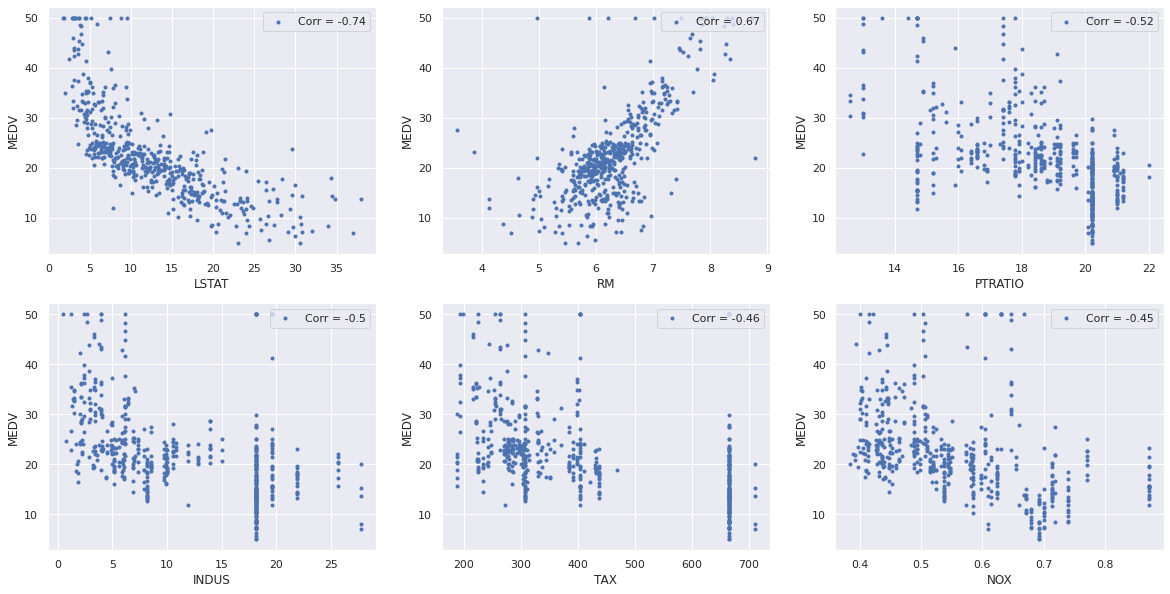

In [95]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))
for i, feature in enumerate(['LSTAT','RM','PTRATIO','INDUS','TAX', 'NOX']):
    corr = corr_matrix[feature]['MEDV']
    axi=ax[i//3][i%3]
    axi.scatter(data[feature], data.MEDV, 
                 label=f'Corr = {corr}',marker='.')
    axi.set_xlabel(feature)
    axi.set_ylabel('MEDV')
    axi.legend(loc='upper right')
plt.show()

In [96]:
# Функция вывода таблиц. Полезна для вывода результатов выбора гиперпараметров 
def draw_table(data, title=['R2'], width=[80, 11]):    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 4) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

# Линейная регрессия 

## Отбор признаков и гиперпараметра

Исследуем метод линейной регрессии. В качестве гиперпараметров рассмотрим тип регуляризации (l1, l2) и ее коэффициент. Также сравним результаты обучения для разного набора признаков

In [ ]:
def CrossValidLin(dataset, regul='l2'):
  KF = KFold(10, random_state=1,shuffle=True)
  number_of_batch = KF.get_n_splits(dataset)
  alphas = [0,1e-3, 1e-2, 1., 100, 1e3]
  scores_alpha = dict()
  scores_text = dict()
  for alpha in tqdm(alphas):
      list_of_scores = []
      for train_index, test_index in tqdm(KF.split(dataset), 
                                          total=number_of_batch, leave=False):
          d_train, d_test = dataset.iloc[train_index], dataset.iloc[train_index]

          #Нормировка признаков и ответов
          scaler = StandardScaler()
          dnorm_train = scaler.fit_transform(d_train)
          dnorm_test = scaler.transform(d_test)
          x_train, x_test = dnorm_train[:,0:-1], dnorm_test[:,0:-1]
          y_train, y_test = dnorm_train[:,-1], dnorm_test[:,-1]

          #выбор регуляризации
          if alpha == 0:
            model = LinearRegression()
          else:
            if regul=='l1':
              model = Lasso(alpha=alpha, fit_intercept=False,normalize=False, random_state=0)
            elif regul=='l2':
              model = Ridge(alpha=alpha, solver='saga', fit_intercept=False,normalize=False, random_state=0)
          #обучение
          model.fit(x_train, y_train)
          #запись результата, R2
          list_of_scores.append(model.score(x_test, y_test))
      scores_text[f'{regul} regularization, alpha = {alpha}'] = [np.mean(list_of_scores)]
      scores_alpha[alpha]= [np.mean(list_of_scores)]
  #отрисовка таблицы с результатами
  draw_table(scores_text, width=[40, 11])
  return scores_alpha

Для начала оставим 2 наиболее скоррелированных признака (LSTAT, RM)

In [ ]:
print('2 most correlated features')
ds = Data_train[['LSTAT','RM','MEDV']]
scores2 = CrossValidLin(ds,regul='l2')
scores2 = CrossValidLin(ds,regul='l1')

Добавим еще 4 признака

In [ ]:
print('6 most correlated features')
ds = Data_train[['LSTAT','RM','INDUS','PTRATIO','TAX','NOX','MEDV']]
scores6 = CrossValidLin(ds, regul='l2')
scores6 = CrossValidLin(ds, regul='l1')

Результат улучшился, попробуем использовать все признаки.

In [ ]:
print('All features')
ds = Data_train
scoresAll = CrossValidLin(ds,regul='l2')
scoresAll = CrossValidLin(ds,regul='l1')

Вспомним, что признаки TAX и RAD сильно скоррелирванны. Попробуем убрать один из них из выборки для обучения.

In [ ]:
print('Without TAX')
ds = Data_train.drop(columns='TAX')
scoresAll = CrossValidLin(ds,regul='l2')
scoresAll = CrossValidLin(ds,regul='l1')

Результат изменился не сильно, но ухудшился, поэтому будем использовать все признаки. Кроме того, как показала кросс-валидация, показатель $R^2$ оказывается наилучшим, если не использовать регуляризацию (alpha = 0).


## Итоговая модель

Обучим модель с отобранным гиперпараметром и проверим результат на отложенной тестовой выборке.

In [ ]:
model = LinearRegression()
model.fit(Dnorm_train.drop(columns=['MEDV']), Dnorm_train['MEDV'])
r2 = model.score(Dnorm_test.drop(columns='MEDV'), Dnorm_test['MEDV'])
r2

Визуализируем результат, построив график предсказанных (Prediciton) значений тестовой выборки от настоящих (Truth) значений.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
X_test = Dnorm_test.drop(columns='MEDV')
ax.plot([-2,3.2], [-2,3.2], color='g')
ax.scatter(model.predict(X_test), Dnorm_test['MEDV'], marker='x', color='r')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.set_title(f"Linear Regression (R2 = {round(r2, 3)})")
plt.show()

# Перцептрон

## Задание класса и функций

In [ ]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=13, num_layers=0, 
                 hidden_dim=16, output_dim=1, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('regression', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
#Функция тестирования работы модели
def testing(model, dataset): 
    # перевод данных в формат тензора
    data_tensor = torch.tensor(np.array(dataset), dtype=torch.float32)
    TensorDataset = torch.utils.data.TensorDataset(data_tensor)

    generator = torch.utils.data.DataLoader(TensorDataset, batch_size=16)
    pred = []
    real = []
    for ds in generator:
        #признаки
        x = ds[0][:,0:13].to(device)
        #ответы
        y = ds[0][:,13].to(device)
        #предсказанные ответы
        py = model(x)[:,0].cpu().tolist()
        pred.extend(py)
        ry = y.cpu().numpy().tolist()
        real.extend(ry)
    # возвращаем метрику R2
    return r2_score(real, pred)

In [ ]:
# Фунцкия применения модели к набору признаков
def Apply(model, dataset):
    # перевод данных в формат тензора 
    data_tensor = torch.tensor(np.array(dataset), dtype=torch.float32)
    TensorDataset = torch.utils.data.TensorDataset(data_tensor)

    generator = torch.utils.data.DataLoader(TensorDataset, batch_size=16)
    pred = []
    for ds in generator:
        x = ds[0].to(device)
        py = model(x)[:,0].cpu().tolist()
        pred.extend(py)
    return pred

In [ ]:
#Функция обучения модели
def trainer(model, dataset, loss_function, optimizer, epochs):
    # перевод данных в формат тензора 
    data_tensor = torch.tensor(np.array(dataset), dtype=torch.float32)
    TensorDataset = torch.utils.data.TensorDataset(data_tensor)

    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(TensorDataset, batch_size=16, 
                                              shuffle=True)
        for ds in tqdm(generator, leave=False):
            optimizer.zero_grad()
            #признаки
            x = ds[0][:,0:-1].to(device)
            #ответы
            y = ds[0][:,-1].to(device)

            output = model(x)[:,0]
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

## Первый тест модели

Необученная модель выдает плохой результат

In [ ]:
model = Perceptron(num_layers=0)
model.to(device)

_ = model.eval()
acc = testing(model, Dnorm_test)
acc

После обучения результат близок к результату для линеной регрессии. Так как количетсво слоев 0, то такой перцептрон соответсвует методу линейной регрессии.

In [ ]:
_ = model.train()
trainer(model=model, 
        dataset=Dnorm_train, 
        loss_function=torch.nn.MSELoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=30)

In [ ]:
_ = model.eval()
r2 = testing(model, Dnorm_test)
r2

## Отбор гиперпараметров

Выберем с помощью кросс-валидации следующие гиперпараметры:


*   размерность скрытого слоя (hidden_dim);
*   количество скрытых слоев (num_layers);
*   количество эпох обучения (epochs);
*   вероятность dropout (p);
*   скорость обучения (lr).



In [ ]:
def CrossValPerceptron(Data_train, grid):
    cross_val = KFold(3, random_state=1,shuffle=True)
    number_of_batch = cross_val.get_n_splits(Data_train)
    scores = dict()
    for item in tqdm(grid):
        list_of_scores = []
        for train_index, test_index in tqdm(cross_val.split(Data_train), 
                                            total=number_of_batch, leave=False):
            Data_train_fold = Data_train.iloc[train_index]
            Data_test_fold = Data_train.iloc[test_index]

            #Нормировка признаков и ответов
            scaler = StandardScaler()
            dnorm_train = scaler.fit_transform(Data_train_fold)
            dnorm_test = scaler.transform(Data_test_fold)

            model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                              hidden_dim=item['hidden_dim'])
            model.to(device)
            #обучение
            _ = model.train()
            trainer(model=model, 
                    dataset=dnorm_train,
                    loss_function=torch.nn.MSELoss(),
                    optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']), 
                    epochs=item['epochs'])
            #тестирование
            _ = model.eval()
            r2 = testing(model, Dnorm_test)
            list_of_scores.append(r2)
        scores[str(item)] = [np.mean(list_of_scores)]
    return scores


In [ ]:
AllScores = dict()
grid = ParameterGrid({'num_layers': [0],
                      'hidden_dim': [0],
                      'p': [0],
                      'lr': [0.001,0.005],
                      'epochs':[15]})
AllScores.update(CrossValPerceptron(Data_train, grid))

In [ ]:
grid = ParameterGrid({'num_layers': [1,2,3,4],
                      'hidden_dim': [20],
                      'p': [0, 0.2],
                      'lr': [0.001,0.005],
                      'epochs':[15]})
AllScores.update(CrossValPerceptron(Data_train, grid))

In [ ]:
grid = ParameterGrid({'num_layers': [1,2,3,4],
                      'hidden_dim': [30],
                      'p': [0, 0.2],
                      'lr': [0.001,0.005],
                      'epochs':[15]})
AllScores.update(CrossValPerceptron(Data_train, grid))

In [ ]:
draw_table(AllScores)

Для наилучшего набора гиперпараметров подберем необходимое количество эпох обучения.

In [ ]:
grid = ParameterGrid({'num_layers': [2],
                      'hidden_dim': [30],
                      'p': [0],
                      'lr': [0.005],
                      'epochs':[10,15,20,25,30,40,50]})
epoch_scores = CrossValPerceptron(Data_train, grid)

In [ ]:
draw_table(epoch_scores)

## Итоговая модель

По результатам кросс-валидации были выбраны следующие гиперпараметры:

*   размерность скрытого слоя hidden_dim=30;
*   количество скрытых слоев num_layers=2;
*   количество эпох обучения epochs=25;
*   вероятность dropout p=0;
*   скорость обучения lr=0.005.

Создадим перцептрон с такими гиперпараметрами, обучим его и протестируем.

In [ ]:
model = Perceptron(num_layers=2, hidden_dim=30, p=0)
model.to(device)

In [ ]:
_ = model.train()
trainer(model=model, 
        dataset=Dnorm_train, 
        loss_function=torch.nn.MSELoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.005), 
        epochs=25)

In [ ]:
_ = model.eval()
r2 = testing(model, Dnorm_test)
r2

Визуализируем результат, построив график предсказанных (Prediciton) значений тестовой выборки от настоящих (Truth) значений.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
X_test = Dnorm_test.drop(columns='MEDV')
ax.plot([-2,3.2], [-2,3.2], color='g')
ax.scatter(Apply(model, X_test), Dnorm_test['MEDV'], marker='x', color='r')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.set_title(f"Perceptron (R2 = {round(r2,3)})")
plt.show()

# SVR

## Отбор гиперпараметров

Сначала выберем ядро SVR

In [ ]:
def CrossValidSVR(dataset):
  KF = KFold(10, random_state=1,shuffle=True)
  number_of_batch = KF.get_n_splits(dataset)
  kernels = ['rbf', 'linear', 'poly', 'sigmoid']
  scores_text = dict()
  scores_kernel = dict()
  for kernel in tqdm(kernels):
      list_of_scores = []
      for train_index, test_index in tqdm(KF.split(dataset), 
                                          total=number_of_batch, leave=False):
          Data_train_fold = dataset.iloc[train_index]
          Data_test_fold = dataset.iloc[test_index]

          #Нормировка признаков и ответов
          scaler = StandardScaler()
          dnorm_train = scaler.fit_transform(Data_train_fold)
          dnorm_test = scaler.transform(Data_test_fold)
          #признаки
          x_train, x_test = dnorm_train[:,0:-1], dnorm_test[:,0:-1]
          #ответы
          y_train, y_test = dnorm_train[:,-1], dnorm_test[:,-1]
          model = SVR(kernel=kernel)
          #обучение
          model.fit(x_train, y_train)
          #тестирование
          list_of_scores.append(model.score(x_test, y_test))
      scores_text[f'kernel = {kernel}'] = [np.mean(list_of_scores)]
      scores_kernel[kernel] = [np.mean(list_of_scores)]
  draw_table(scores_text, width=[25, 11])
  return scores_kernel

In [ ]:
scores = CrossValidSVR(Data_train)
best_kernel = sorted(scores, key=lambda x: scores[x], reverse=True)[0]
print(f'Best kernel: {best_kernel}')

Лучший показатель у ядра rbf (радиальная базисная функция). Подберем еще один гиперпараметр -- коэффициент регуляризации.

In [ ]:
def CrossValidSVRc(dataset):
  KF = KFold(10, random_state=1,shuffle=True)
  number_of_batch = KF.get_n_splits(dataset)
  Cs = [1e-3,1e-2,1e-1,1,5,10,15,20,25,50]
  scores_text = dict()
  scores_C = dict()
  for C in tqdm(Cs):
      list_of_scores = []
      for train_index, test_index in tqdm(KF.split(dataset), 
                                          total=number_of_batch, leave=False):
          Data_train_fold = dataset.iloc[train_index]
          Data_test_fold = dataset.iloc[test_index]

          #Нормировка признаков и ответов
          scaler = StandardScaler()
          dnorm_train = scaler.fit_transform(Data_train_fold)
          dnorm_test = scaler.transform(Data_test_fold)
          #признаки
          x_train, x_test = dnorm_train[:,0:-1], dnorm_test[:,0:-1]
          #ответы
          y_train, y_test = dnorm_train[:,-1], dnorm_test[:,-1]
          model = SVR(kernel='rbf', C=C)
          #обучение
          model.fit(x_train, y_train)
          #тестирование
          list_of_scores.append(model.score(x_test, y_test))
      scores_text[f'C = {C}'] = [np.mean(list_of_scores)]
      scores_C[C] = [np.mean(list_of_scores)]
  draw_table(scores_text, width=[25, 11])
  return scores_C

In [ ]:
scores_c = CrossValidSVRc(Data_train)
best_C = sorted(scores_c, key=lambda x: scores_c[x], reverse=True)[0]
print(f'Best C: {best_C}')

## Итоговая модель

По результатам кросс-валидации было выбрано ядро rbf и коэффициент регуляризации $C=20$.

Для отобранных гиперпараметров оценим результат на отложенной тестовой выборке.

In [98]:
model = SVR(kernel=best_kernel, C=best_C)
_ = model.fit(Dnorm_train.drop(columns=['MEDV']), Dnorm_train['MEDV'])
r2 = model.score(Dnorm_test.drop(columns=['MEDV']), Dnorm_test['MEDV'])

268

Визуализируем результат, построив график предсказанных (Prediciton) значений тестовой выборки от настоящих (Truth) значений.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
X_test = Dnorm_test.drop(columns='MEDV')
ax.plot([-2,3.2], [-2,3.2], color='g')
ax.scatter(model.predict(X_test), Dnorm_test['MEDV'], marker='x', color='r')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.set_title(f"SVR (R2 = {round(r2,3)})")
plt.show()

# Вывод

В данной работе исследовалась задача регрессии на примере данных о жилье в Бостоне. Были рассмотрены три метода: линейная регрессия, полносвязная нейронная сеть (перцептрон) и метод опорных векторов для регрессии (SVR).
Для каждого из методов были отобраны гиперпараметры с помощью кросс-валидации. В качестве метрики для оценки качества модели использовался коэффициент детерминации ($R^2$). 

Линейная регрессия показала неплохой результат, $R^2=0,76$. При этом наилучшая точность достигается без регуляризации и с использованием всех признаков. Значительно лучшие результаты показали модели перцептрон и SVR, $R^2 > 0,9$. Это ожидаемо и связано с тем, что настоящая зависимость не линейная. В перцептроне нелинейность вносится в скрытых слоях, а в SVR с помощью ядер.

Стоит отметить, что гиперпараметры для перцептрона отбирались достаточно грубо, рассматривалось небольшое количество значений. Ограничения Google Colab не позволяли исследовать сразу большие сетки гиперпараметров. Но тем не менее, модель перцептрон дает наиболее точный результат. А при более тщательном отборе гиперпараметров, вероятно, точность может стать еще больше.